### Neural Networks from scratch

In this notebook we define a multi-layer perceptron and a convolutional neural network which we train from scratch

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage import io, transform

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
import time
import copy

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from PIL import Image

### Dataset creation

In [2]:
subset = 'train'
resized = 'resized2'

folder = "."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep

#Create mapping for labels, labels must be continuous numbers from 0 to n_classes-1
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [3]:
# Plot image for testing
def show_image(image, label):
    plt.imshow(image)
    plt.title(label)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
# Extension of the PyTorch DataSet class which uses our data
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transforms to be applied
                on a sample.
            classes_map (dictionary): Mapping from labels to integers
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes_map = classes 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = Image.fromarray(sample['image'])
            sample['image'] = self.transform(sample['image'])

        return sample

In [5]:
# Loading our data 
resized = 'resized2'
folder = "."+os.sep+"data"+os.sep

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Validation Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
valset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

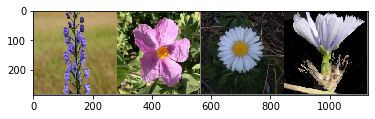

   39    12     2     6


In [6]:
# Show 4 random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
batch = dataiter.next()
images, labels = batch['image'], batch['label']

# Show 4 random images and their labels to test our dataset works properly
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].data.numpy() for j in range(4)))

### Function definition

In [8]:
# Function to train our neural network takes as input a model, a criterion, an optimizer an scheduler
# and the number of epochs we will train the network for

# Returns the best model found over the training, and history of the training and validation accuracy
# over each epoch
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {"train" : list(), "val": list()}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data['image'].to(device), data['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            history[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
# Plots the training and validation accuracies after training a network, the plot can be saved as an image
def plot_history(history, savepath = None):
    plt.plot(history['train'])
    plt.plot(history['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    ticks = list(range(len(history['train'])))
    names = list(range(1,len(history['train'])+1))
    plt.xticks(ticks, names)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

In [11]:
# Gets the prediction array for the specified model and dataset
def get_preds(net, loader):
    preds = list()
    with torch.no_grad():
        for data in loader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().detach().numpy())
    return preds

In [12]:
# Computes the accuracy for the specified model and dataset
def get_accuracy(net, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 695 test images: %d %%' % (100 * correct / total))

In [13]:
# Plots the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(32, 24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [14]:
# Computes how many parameters there are in a network
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

### Convolutional Neural Network

In [ ]:
# Convolutional Neural Network Architecture
class Net(nn.Module):
    # Defining the layers in the network
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) 
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(32 * 67 * 67, 1024) 
        self.fc2 = nn.Linear(1024, 50) 

    # Defining the forward pass of our network
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 32 * 67 * 67)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
# Optmization
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# Use the GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=143648, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=50, bias=True)
)

In [17]:
net, history = train_model(net, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.8928 Acc: 0.0336
val Loss: 3.8127 Acc: 0.0446

Epoch 1/24
----------
train Loss: 3.4383 Acc: 0.1056
val Loss: 3.0939 Acc: 0.1942

Epoch 2/24
----------
train Loss: 2.8545 Acc: 0.2274
val Loss: 2.7465 Acc: 0.2446

Epoch 3/24
----------
train Loss: 2.3304 Acc: 0.3508
val Loss: 2.8443 Acc: 0.2691

Epoch 4/24
----------
train Loss: 1.8574 Acc: 0.4846
val Loss: 2.6891 Acc: 0.2863

Epoch 5/24
----------
train Loss: 1.5752 Acc: 0.5701
val Loss: 3.9700 Acc: 0.2086

Epoch 6/24
----------
train Loss: 1.1872 Acc: 0.6588
val Loss: 3.3580 Acc: 0.2691

Epoch 7/24
----------
train Loss: 0.3444 Acc: 0.9031
val Loss: 3.1768 Acc: 0.3439

Epoch 8/24
----------
train Loss: 0.1101 Acc: 0.9750
val Loss: 3.4223 Acc: 0.3540

Epoch 9/24
----------
train Loss: 0.0541 Acc: 0.9890
val Loss: 3.7145 Acc: 0.3583

Epoch 10/24
----------
train Loss: 0.0317 Acc: 0.9962
val Loss: 3.9171 Acc: 0.3640

Epoch 11/24
----------
train Loss: 0.0189 Acc: 0.9971
val Loss: 4.1316 Acc: 0.3683

Ep

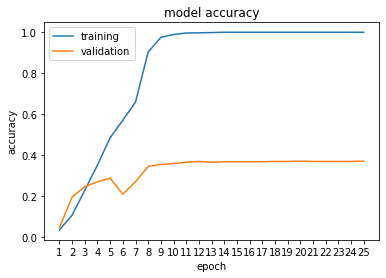

In [18]:
plot_history(history,'plots' + os.sep + 'cnn.png')

In [19]:
y_predict = get_preds(net, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)

In [20]:
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.31510791366906477
Rappel: 0.31510791366906477
Precision: 0.30727019073813805
F-Measure: 0.3050633703277806


d:\onedrive\documentos\github\classificationplantes\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\onedrive\documentos\github\classificationplantes\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


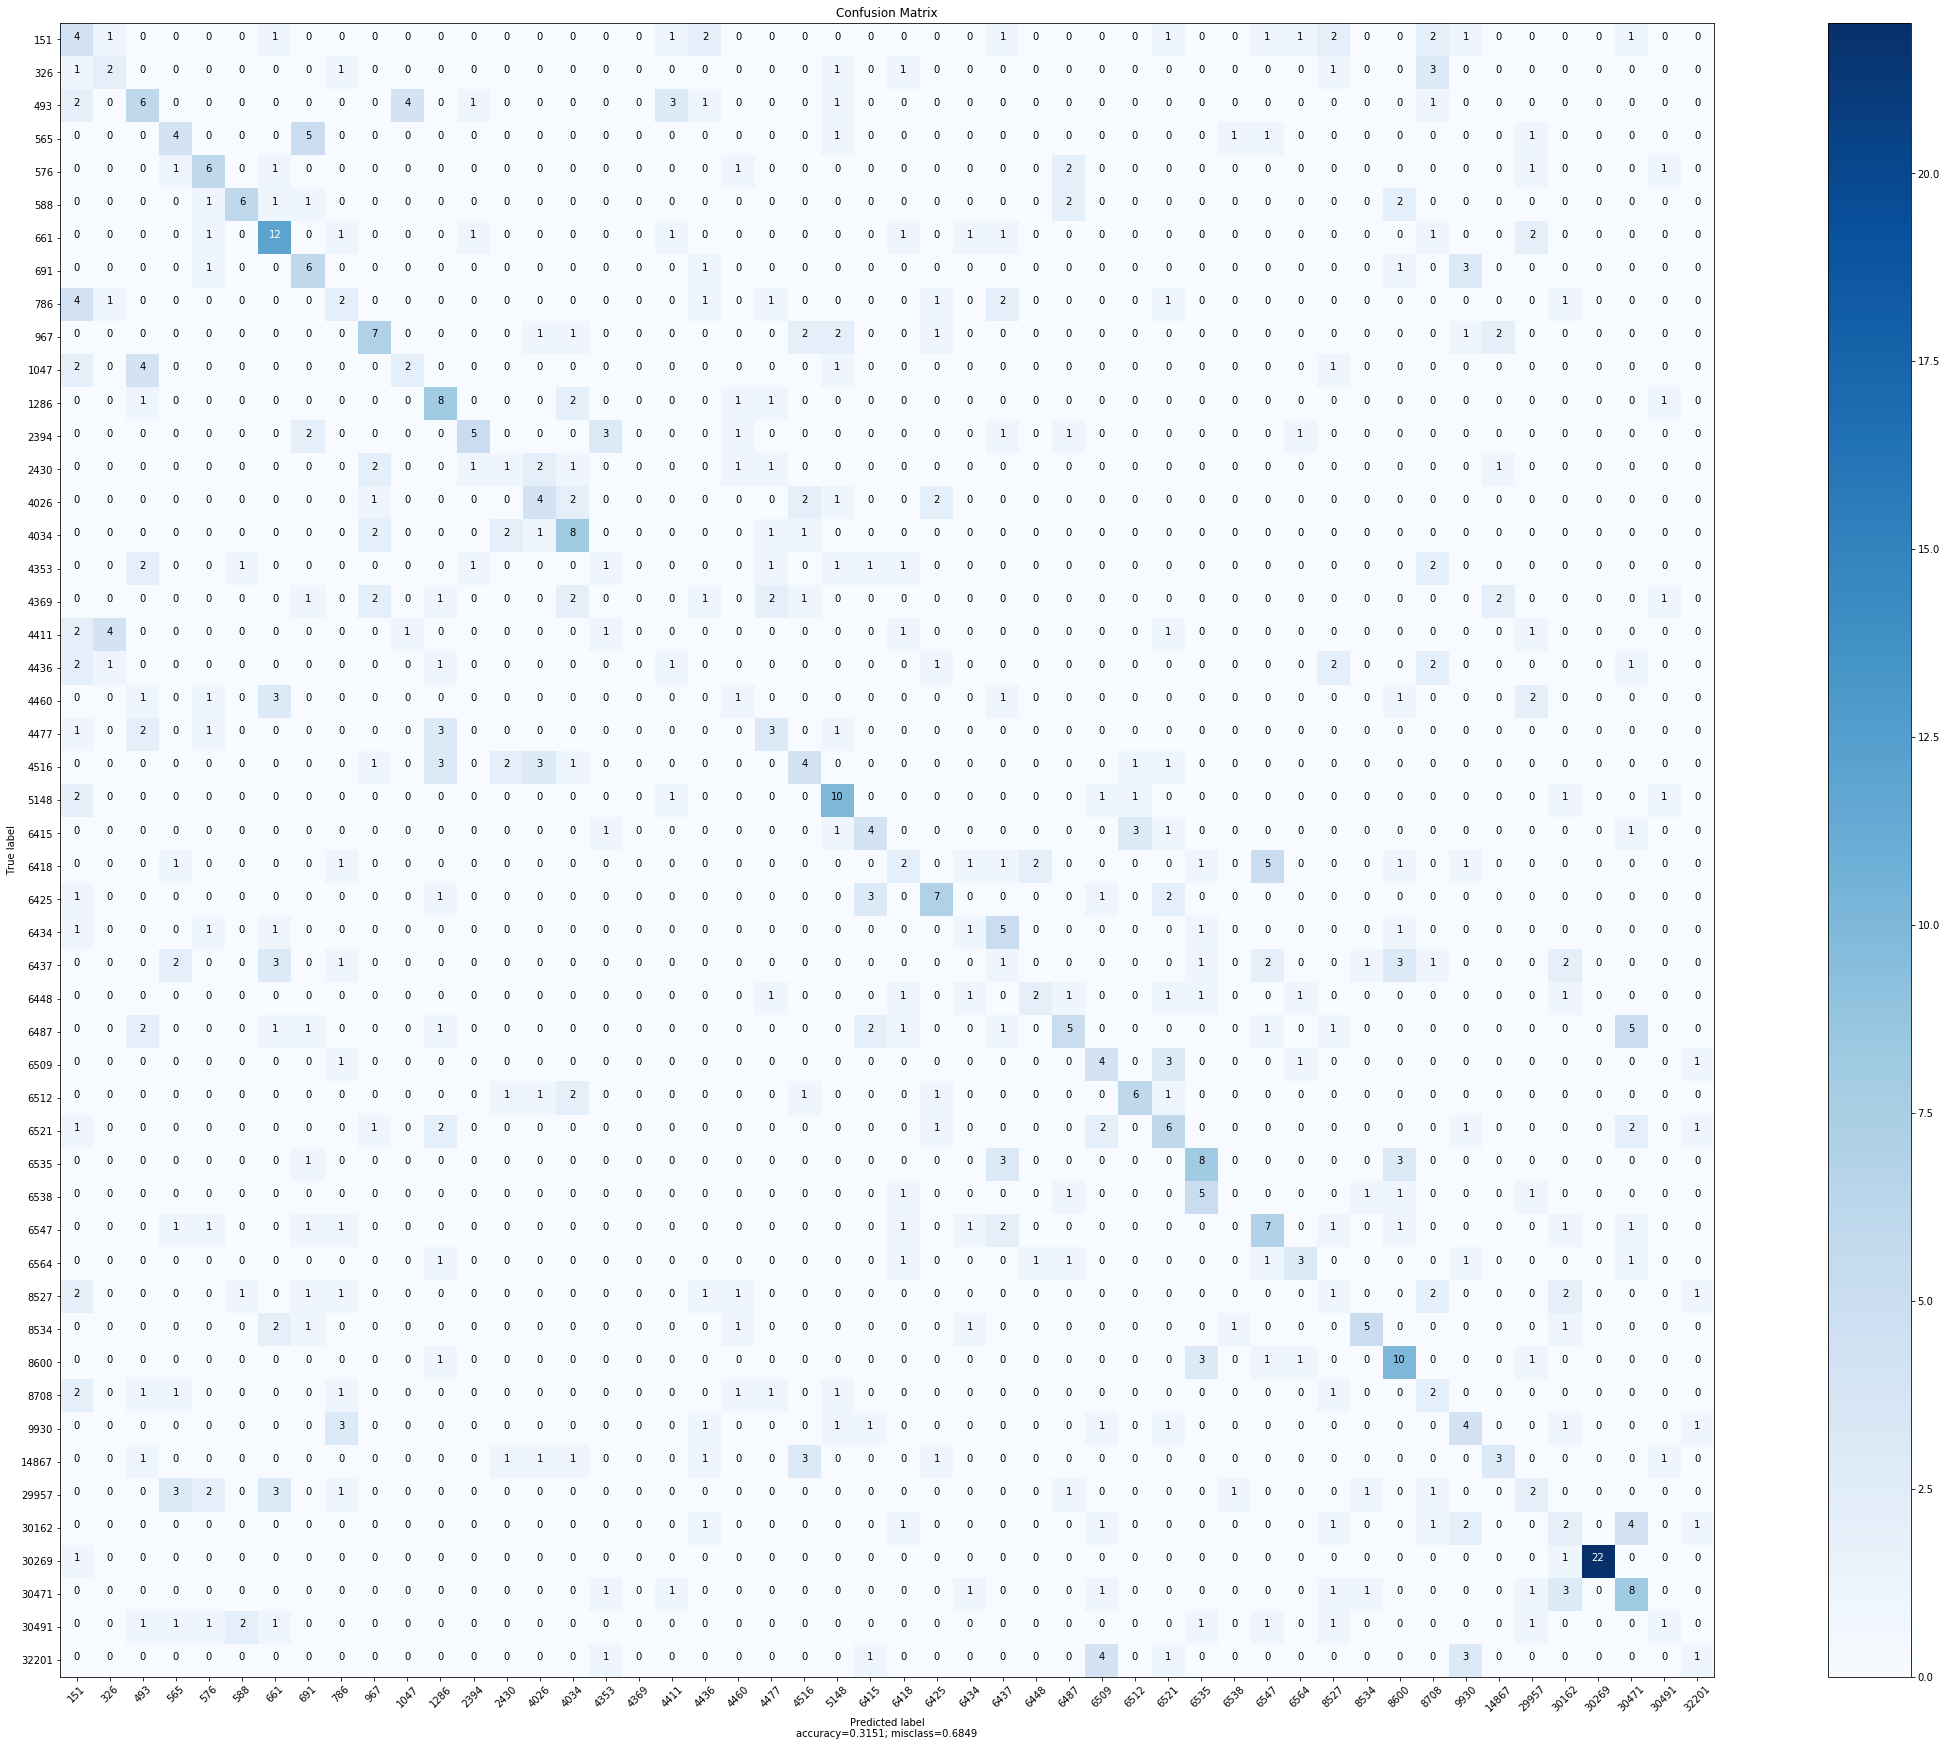

In [22]:
cm = confusion_matrix(y_true, y_predict)
plot_confusion_matrix(cm = cm, normalize = False, target_names = classes, title = "Confusion Matrix")

### Perceptron

In [28]:
resized = 'resized2'
folder = "."+os.sep+"data"+os.sep

#Transformation dans un Tensor (comme une liste) et les valeur de chaque pixel (de 0 à 255) sont converti de 0 à 1
transform = transforms.Compose([transforms.Resize(100),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#note : pour ne pas faire la decente de gradient par apport à la moyenne des tesst sur toute les image, nous entrainons sur des mini batch de 4 images

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Validation Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
valset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

In [29]:
# Perceptron architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*100*3, 3000) 
        self.fc2 = nn.Linear(3000, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 50)
        
    def forward(self, x):
        x = x.view(-1, 100 * 100 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [30]:
mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)

MLP(
  (fc1): Linear(in_features=30000, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
)

In [32]:
mlp, history = train_model(mlp, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.8152 Acc: 0.0542
val Loss: 3.5792 Acc: 0.1180

Epoch 1/24
----------
train Loss: 3.2567 Acc: 0.1574
val Loss: 3.0513 Acc: 0.1727

Epoch 2/24
----------
train Loss: 2.8615 Acc: 0.2006
val Loss: 2.9230 Acc: 0.1986

Epoch 3/24
----------
train Loss: 2.5497 Acc: 0.2711
val Loss: 2.7083 Acc: 0.2345

Epoch 4/24
----------
train Loss: 2.2485 Acc: 0.3551
val Loss: 2.7990 Acc: 0.2317

Epoch 5/24
----------
train Loss: 1.9482 Acc: 0.4304
val Loss: 2.7952 Acc: 0.2633

Epoch 6/24
----------
train Loss: 1.6877 Acc: 0.5048
val Loss: 2.8314 Acc: 0.2619

Epoch 7/24
----------
train Loss: 1.0219 Acc: 0.7298
val Loss: 2.6128 Acc: 0.3367

Epoch 8/24
----------
train Loss: 0.8369 Acc: 0.7869
val Loss: 2.7059 Acc: 0.3252

Epoch 9/24
----------
train Loss: 0.7537 Acc: 0.8090
val Loss: 2.7384 Acc: 0.3468

Epoch 10/24
----------
train Loss: 0.6839 Acc: 0.8378
val Loss: 2.7616 Acc: 0.3482

Epoch 11/24
----------
train Loss: 0.6279 Acc: 0.8455
val Loss: 2.8123 Acc: 0.3324

Ep

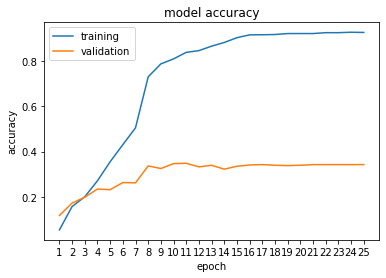

In [33]:
plot_history(history,'plots' + os.sep + 'mlp.png')

In [34]:
y_predict = get_preds(mlp, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)

In [35]:
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.2892086330935252
Rappel: 0.2892086330935252
Precision: 0.29409899883975565
F-Measure: 0.28554380664965595


### Counting the number of parameters in both networks

In [36]:
get_n_params(mlp)

90938450

In [37]:
get_n_params(net)

147164482